In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


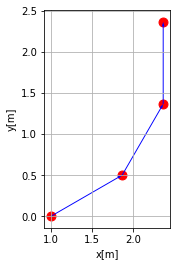

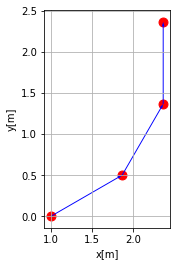

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 5000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_V_STEP = 0.3 / DATA_NUM_WAYPOINTS # [m/step]
DATA_MAX_V_STEP = 0.5 / DATA_NUM_WAYPOINTS # [m/step]
DATA_W_STEP = xp.pi * 0.5 / DATA_NUM_WAYPOINTS # [rad/step]
DATA_MAX_W_STEP = xp.pi * 0.5 / DATA_NUM_WAYPOINTS # [rad/step]
DATA_RANGE_TRANSLATE = 0 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :5000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.03
DATA_MAX_V_STEP      :0.05
DATA_W_STEP          :0.15707963267948966
DATA_MAX_W_STEP      :0.15707963267948966
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [6]:
X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

5000
(10, 3)


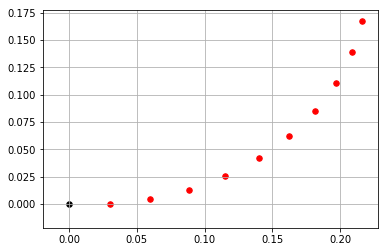

 -- x_train -- 
[[ 2.99731391e-02 -1.23545503e-08 -1.35088091e+00]
 [ 5.96247279e-02  4.37861183e-03 -1.20427091e+00]
 [ 8.83185613e-02  1.30419247e-02 -1.05766091e+00]
 [ 1.15438984e-01  2.58040461e-02 -9.11050915e-01]
 [ 1.40404100e-01  4.23911516e-02 -7.64440915e-01]
 [ 1.62678256e-01  6.24473481e-02 -6.17830915e-01]
 [ 1.81783539e-01  8.55423094e-02 -4.71220915e-01]
 [ 1.97310025e-01  1.11180510e-01 -3.24610915e-01]
 [ 2.08924577e-01  1.38811855e-01 -1.78000915e-01]
 [ 2.16377993e-01  1.67843487e-01 -3.13909146e-02]]


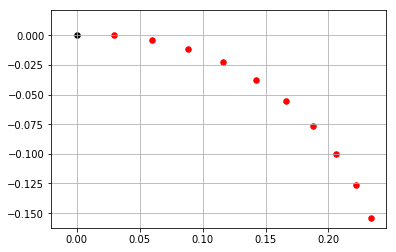

 -- x_train -- 
[[ 2.99790933e-02  3.96519729e-08 -1.76480765e+00]
 [ 5.97077835e-02 -3.86661500e-03 -1.89414765e+00]
 [ 8.86894370e-02 -1.15353694e-02 -2.02348765e+00]
 [ 1.16439900e-01 -2.28781131e-02 -2.15282765e+00]
 [ 1.42495587e-01 -3.77053595e-02 -2.28216765e+00]
 [ 1.66421223e-01 -5.57694115e-02 -2.41150765e+00]
 [ 1.87817118e-01 -7.67684998e-02 -2.54084765e+00]
 [ 2.06325842e-01 -1.00351823e-01 -2.67018765e+00]
 [ 2.21638198e-01 -1.26125411e-01 -2.79952765e+00]
 [ 2.33498385e-01 -1.53658700e-01 -2.92886765e+00]]


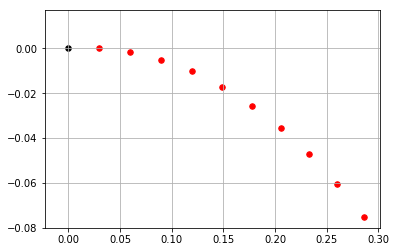

 -- x_train -- 
[[ 2.99959132e-02  7.48274859e-08 -1.65656882e+00]
 [ 5.99428075e-02 -1.71408230e-03 -1.71374882e+00]
 [ 8.97427965e-02 -5.13686838e-03 -1.77092882e+00]
 [ 1.19298474e-01 -1.02570955e-02 -1.82810882e+00]
 [ 1.48513233e-01 -1.70580273e-02 -1.88528882e+00]
 [ 1.77291580e-01 -2.55174340e-02 -1.94246882e+00]
 [ 2.05539448e-01 -3.56076645e-02 -1.99964882e+00]
 [ 2.33164505e-01 -4.72957373e-02 -2.05682882e+00]
 [ 2.60076453e-01 -6.05434480e-02 -2.11400882e+00]
 [ 2.86187328e-01 -7.53074944e-02 -2.17118882e+00]]


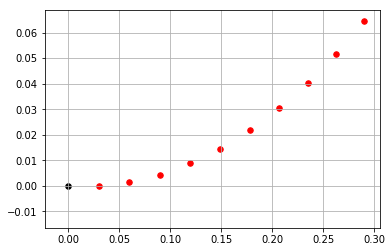

 -- x_train -- 
[[ 2.99970428e-02 -7.09131753e-08 -1.49783396e+00]
 [ 5.99586117e-02  1.45833917e-03 -1.44919396e+00]
 [ 8.98138363e-02  4.37178055e-03 -1.40055396e+00]
 [ 1.19492097e-01  8.73336181e-03 -1.35191396e+00]
 [ 1.48923195e-01  1.45327662e-02 -1.30327396e+00]
 [ 1.78037512e-01  2.17562758e-02 -1.25463396e+00]
 [ 2.06766183e-01  3.03868043e-02 -1.20599396e+00]
 [ 2.35041254e-01  4.04039372e-02 -1.15735396e+00]
 [ 2.62795843e-01  5.17839801e-02 -1.10871396e+00]
 [ 2.89964300e-01  6.45000149e-02 -1.06007396e+00]]


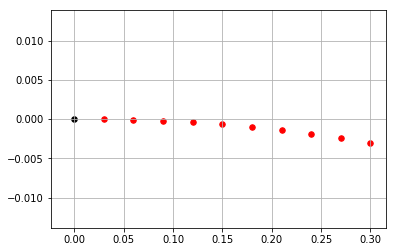

 -- x_train -- 
[[ 2.99999935e-02  9.41270269e-08 -1.57421946e+00]
 [ 5.99999092e-02 -6.82116721e-05 -1.57649946e+00]
 [ 8.99995913e-02 -2.04917042e-04 -1.57877946e+00]
 [ 1.19998884e-01 -4.10021273e-04 -1.58105946e+00]
 [ 1.49997630e-01 -6.83523298e-04 -1.58333946e+00]
 [ 1.79995676e-01 -1.02542170e-03 -1.58561946e+00]
 [ 2.09992863e-01 -1.43571469e-03 -1.58789946e+00]
 [ 2.39989038e-01 -1.91440014e-03 -1.59017946e+00]
 [ 2.69984042e-01 -2.46147557e-03 -1.59245946e+00]
 [ 2.99977722e-01 -3.07693813e-03 -1.59473946e+00]]


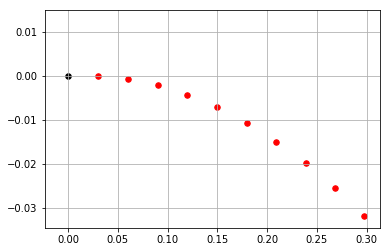

 -- x_train -- 
[[ 2.99992955e-02  1.26901432e-07 -1.60641056e+00]
 [ 5.99901408e-02 -7.11862614e-04 -1.63015056e+00]
 [ 8.99556343e-02 -2.13556730e-03 -1.65389056e+00]
 [ 1.19878888e-01 -4.27018480e-03 -1.67763056e+00]
 [ 1.49743040e-01 -7.11451214e-03 -1.70137056e+00]
 [ 1.79531258e-01 -1.06669464e-02 -1.72511056e+00]
 [ 2.09226756e-01 -1.49254855e-02 -1.74885056e+00]
 [ 2.38812797e-01 -1.98877295e-02 -1.77259056e+00]
 [ 2.68272710e-01 -2.55508819e-02 -1.79633056e+00]
 [ 2.97589890e-01 -3.19117512e-02 -1.82007056e+00]]


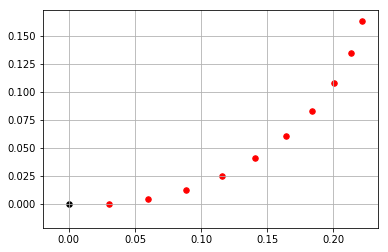

 -- x_train -- 
[[ 2.99750315e-02 -5.53300710e-08 -1.35876948e+00]
 [ 5.96511211e-02  4.22276569e-03 -1.21741948e+00]
 [ 8.84363323e-02  1.25842322e-02 -1.07606948e+00]
 [ 1.15756499e-01  2.49175616e-02 -9.34719481e-01]
 [ 1.41066677e-01  4.09767462e-02 -7.93369481e-01]
 [ 1.63862014e-01  6.04414601e-02 -6.52019481e-01]
 [ 1.83687823e-01  8.29234489e-02 -5.10669481e-01]
 [ 2.00148646e-01  1.07974274e-01 -3.69319481e-01]
 [ 2.12916145e-01  1.35094257e-01 -2.27969481e-01]
 [ 2.21735653e-01  1.63742447e-01 -8.66194809e-02]]


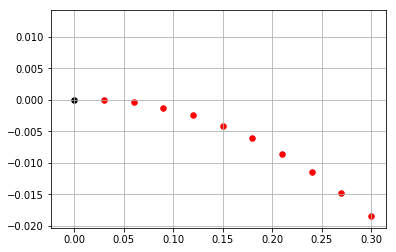

 -- x_train -- 
[[ 2.99997681e-02  4.51814728e-08 -1.59122783e+00]
 [ 5.99967544e-02 -4.08493850e-04 -1.60484783e+00]
 [ 8.99853942e-02 -1.22554131e-03 -1.61846783e+00]
 [ 1.19960125e-01 -2.45094564e-03 -1.63208783e+00]
 [ 1.49915386e-01 -4.08447951e-03 -1.64570783e+00]
 [ 1.79845620e-01 -6.12583992e-03 -1.65932783e+00]
 [ 2.09745276e-01 -8.57464817e-03 -1.67294783e+00]
 [ 2.39608807e-01 -1.14304500e-02 -1.68656783e+00]
 [ 2.69430673e-01 -1.46927157e-02 -1.70018783e+00]
 [ 2.99205343e-01 -1.83608401e-02 -1.71380783e+00]]


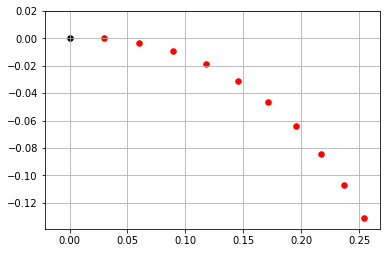

 -- x_train -- 
[[ 2.99859490e-02  1.43458813e-07 -1.72984611e+00]
 [ 5.98035147e-02 -3.17317006e-03 -1.83587611e+00]
 [ 8.91177910e-02 -9.48429845e-03 -1.94190611e+00]
 [ 1.17599525e-01 -1.88623561e-02 -2.04793611e+00]
 [ 1.44928815e-01 -3.12020104e-02 -2.15396611e+00]
 [ 1.70798702e-01 -4.63646643e-02 -2.25999611e+00]
 [ 1.94918621e-01 -6.41800134e-02 -2.36602611e+00]
 [ 2.17017660e-01 -8.44479587e-02 -2.47205611e+00]
 [ 2.36847607e-01 -1.06940854e-01 -2.57808611e+00]
 [ 2.54185735e-01 -1.31406063e-01 -2.68411611e+00]]


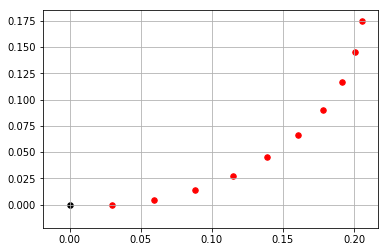

 -- x_train -- 
[[ 2.99693197e-02 -3.30933034e-08 -1.33576022e+00]
 [ 5.95714970e-02  4.67663510e-03 -1.17907022e+00]
 [ 8.80812322e-02  1.39154189e-02 -1.02238022e+00]
 [ 1.14799992e-01  2.74899536e-02 -8.65690223e-01]
 [ 1.39073125e-01  4.50676419e-02 -7.09000223e-01]
 [ 1.60305902e-01  6.62178030e-02 -5.52310223e-01]
 [ 1.77978086e-01  9.04222247e-02 -3.95620223e-01]
 [ 1.91656682e-01  1.17087861e-01 -2.38930223e-01]
 [ 2.01006541e-01  1.45561362e-01 -8.22402226e-02]
 [ 2.05798579e-01  1.75145082e-01  7.44497774e-02]]


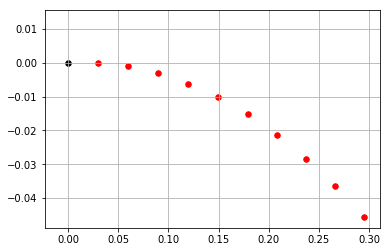

 -- x_train -- 
[[ 2.99985550e-02  9.73316284e-08 -1.62179957e+00]
 [ 5.99797759e-02 -1.01955976e-03 -1.65579957e+00]
 [ 8.99090076e-02 -3.05779268e-03 -1.68979957e+00]
 [ 1.19751655e-01 -6.11224544e-03 -1.72379957e+00]
 [ 1.49473224e-01 -1.01793874e-02 -1.75779957e+00]
 [ 1.79039359e-01 -1.52545175e-02 -1.79179957e+00]
 [ 2.08415886e-01 -2.13317694e-02 -1.82579957e+00]
 [ 2.37568848e-01 -2.84041184e-02 -1.85979957e+00]
 [ 2.66464547e-01 -3.64633898e-02 -1.89379957e+00]
 [ 2.95069584e-01 -4.55002678e-02 -1.92779957e+00]]


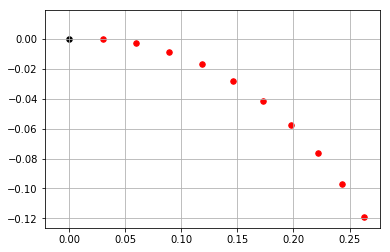

 -- x_train -- 
[[ 2.99888101e-02  1.14936932e-08 -1.71272671e+00]
 [ 5.98434773e-02 -2.83328611e-03 -1.80734671e+00]
 [ 8.92969138e-02 -8.47454537e-03 -1.90196671e+00]
 [ 1.18085621e-01 -1.68732981e-02 -1.99658671e+00]
 [ 1.45952048e-01 -2.79544068e-02 -2.09120671e+00]
 [ 1.72646895e-01 -4.16187369e-02 -2.18582671e+00]
 [ 1.97931341e-01 -5.77440436e-02 -2.28044671e+00]
 [ 2.21579185e-01 -7.61860658e-02 -2.37506671e+00]
 [ 2.43378868e-01 -9.67798160e-02 -2.46968671e+00]
 [ 2.63135364e-01 -1.19341057e-01 -2.56430671e+00]]


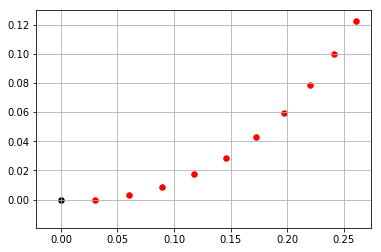

 -- x_train -- 
[[ 2.99880649e-02 -9.53553115e-08 -1.42421315e+00]
 [ 5.98330721e-02  2.92558179e-03 -1.32649315e+00]
 [ 8.92502522e-02  8.74911580e-03 -1.22877315e+00]
 [ 1.17958918e-01  1.74149408e-02 -1.13105315e+00]
 [ 1.45685144e-01  2.88403710e-02 -1.03333315e+00]
 [ 1.72164376e-01  4.29163894e-02 -9.35613147e-01]
 [ 1.97143961e-01  5.95086884e-02 -8.37893147e-01]
 [ 2.20385553e-01  7.84589507e-02 -7.40173147e-01]
 [ 2.41667390e-01  9.95863605e-02 -6.42453147e-01]
 [ 2.60786410e-01  1.22689329e-01 -5.44733147e-01]]


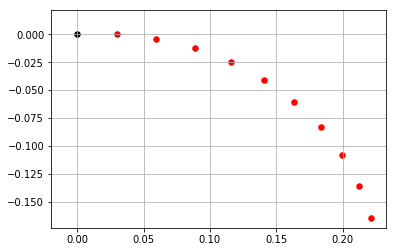

 -- x_train -- 
[[ 2.99748120e-02  1.34020526e-07 -1.78375580e+00]
 [ 5.96480716e-02 -4.24097641e-03 -1.92572580e+00]
 [ 8.84227039e-02 -1.26379932e-02 -2.06769580e+00]
 [ 1.15719716e-01 -2.50219544e-02 -2.20966580e+00]
 [ 1.40989846e-01 -4.11436743e-02 -2.35163580e+00]
 [ 1.63724619e-01 -6.06787574e-02 -2.49360580e+00]
 [ 1.83466572e-01 -8.32341256e-02 -2.63557580e+00]
 [ 1.99818466e-01 -1.08355928e-01 -2.77754580e+00]
 [ 2.12451272e-01 -1.35538671e-01 -2.91951580e+00]
 [ 2.21110799e-01 -1.64235395e-01 -3.06148580e+00]]


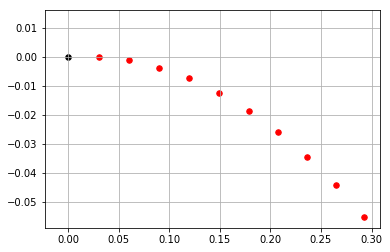

 -- x_train -- 
[[ 2.99978535e-02  5.16131013e-08 -1.63295805e+00]
 [ 5.99699555e-02 -1.24265210e-03 -1.67439805e+00]
 [ 8.98648431e-02 -3.72597739e-03 -1.71583805e+00]
 [ 1.19631186e-01 -7.44566031e-03 -1.75727805e+00]
 [ 1.49217875e-01 -1.23953141e-02 -1.79871805e+00]
 [ 1.78574108e-01 -1.85664400e-02 -1.84015805e+00]
 [ 2.07649480e-01 -2.59484420e-02 -1.88159805e+00]
 [ 2.36394067e-01 -3.45286451e-02 -1.92303805e+00]
 [ 2.64758516e-01 -4.42923167e-02 -1.96447805e+00]
 [ 2.92694122e-01 -5.52226925e-02 -2.00591805e+00]]


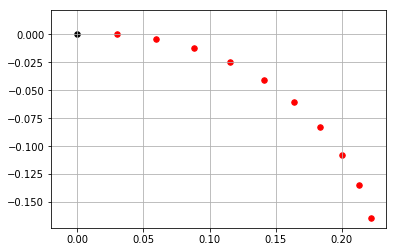

 -- x_train -- 
[[ 2.99750103e-02  1.26170610e-07 -1.78291554e+00]
 [ 5.96508354e-02 -4.22440229e-03 -1.92432554e+00]
 [ 8.84350425e-02 -1.25892490e-02 -2.06573554e+00]
 [ 1.15752998e-01 -2.49274226e-02 -2.20714554e+00]
 [ 1.41059341e-01 -4.09926100e-02 -2.34855554e+00]
 [ 1.63848869e-01 -6.04640940e-02 -2.48996554e+00]
 [ 1.83666622e-01 -8.29531559e-02 -2.63137554e+00]
 [ 2.00116969e-01 -1.08010836e-01 -2.77278554e+00]
 [ 2.12871504e-01 -1.35136894e-01 -2.91419554e+00]
 [ 2.21675603e-01 -1.63789802e-01 -3.05560554e+00]]


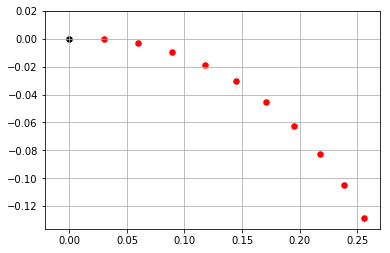

 -- x_train -- 
[[ 2.99866089e-02  2.76296393e-09 -1.72606142e+00]
 [ 5.98127184e-02 -3.09836862e-03 -1.82957142e+00]
 [ 8.91590472e-02 -9.26194684e-03 -1.93308142e+00]
 [ 1.17711450e-01 -1.84247523e-02 -2.03659142e+00]
 [ 1.45164280e-01 -3.04886994e-02 -2.14010142e+00]
 [ 1.71223662e-01 -4.53246464e-02 -2.24361142e+00]
 [ 1.95610637e-01 -6.27737783e-02 -2.34712142e+00]
 [ 2.18064146e-01 -8.26493062e-02 -2.45063142e+00]
 [ 2.38343832e-01 -1.04738468e-01 -2.55414142e+00]
 [ 2.56232606e-01 -1.28804803e-01 -2.65765142e+00]]


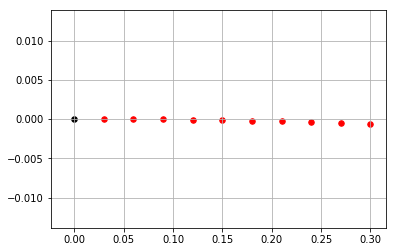

 -- x_train -- 
[[ 2.99999997e-02  1.36175522e-07 -1.57147587e+00]
 [ 5.99999965e-02 -1.32276484e-05 -1.57192587e+00]
 [ 8.99999842e-02 -4.00914691e-05 -1.57237587e+00]
 [ 1.19999957e-01 -8.04552810e-05 -1.57282587e+00]
 [ 1.49999908e-01 -1.34319076e-04 -1.57327587e+00]
 [ 1.79999832e-01 -2.01682843e-04 -1.57372587e+00]
 [ 2.09999723e-01 -2.82546569e-04 -1.57417587e+00]
 [ 2.39999574e-01 -3.76910237e-04 -1.57462587e+00]
 [ 2.69999380e-01 -4.84773829e-04 -1.57507587e+00]
 [ 2.99999135e-01 -6.06137321e-04 -1.57552587e+00]]


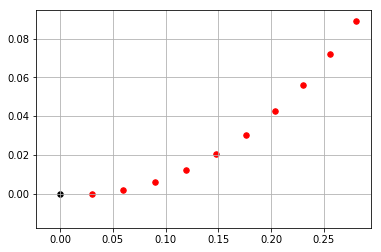

 -- x_train -- 
[[ 2.99941539e-02 -1.48393416e-07 -1.46820638e+00]
 [ 5.99182010e-02  2.04940506e-03 -1.39981638e+00]
 [ 8.96322354e-02  6.13907795e-03 -1.33142638e+00]
 [ 1.18997333e-01  1.22497495e-02 -1.26303638e+00]
 [ 1.47876201e-01  2.03528502e-02 -1.19464638e+00]
 [ 1.76133820e-01  3.04104949e-02 -1.12625638e+00]
 [ 2.03638076e-01  4.23756604e-02 -1.05786638e+00]
 [ 2.30260376e-01  5.61924053e-02 -9.89476379e-01]
 [ 2.55876250e-01  7.17961310e-02 -9.21086379e-01]
 [ 2.80365935e-01  8.91138845e-02 -8.52696379e-01]]


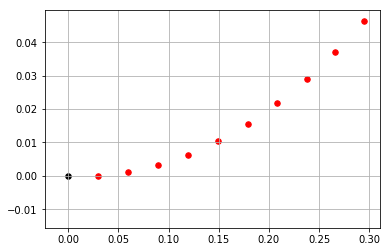

 -- x_train -- 
[[ 2.99985053e-02 -6.29197369e-08 -1.51892423e+00]
 [ 5.99790788e-02  1.03701578e-03 -1.48434423e+00]
 [ 8.99058740e-02  3.10999612e-03 -1.44976423e+00]
 [ 1.19743109e-01  6.21639952e-03 -1.41518423e+00]
 [ 1.49455108e-01  1.03525118e-02 -1.38060423e+00]
 [ 1.79006346e-01  1.55133875e-02 -1.34602423e+00]
 [ 2.08361490e-01  2.16928561e-02 -1.31144423e+00]
 [ 2.37485442e-01  2.88835291e-02 -1.27686423e+00]
 [ 2.66343378e-01  3.70768088e-02 -1.24228423e+00]
 [ 2.94900795e-01  4.62628988e-02 -1.20770423e+00]]


In [7]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [19]:
# loss
def error_squares(z_oplus,z_true):
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    print('t',t)
    print('p',p.data)
    error = F.sqrt(F.sum((t-p)*(t-p)))
    print(error)
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = e_diff_v + error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_diff_v) + '\t'
    '''
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_diff_w) + '\t'
    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [9]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            # forward
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # clip
            v_limit = DATA_MAX_V_STEP
            w_limit = DATA_MAX_W_STEP
            v = F.expand_dims(F.transpose(F.clip(y[:,:,0],-v_limit,v_limit)),axis=0)
            w = F.expand_dims(F.transpose(F.clip(y[:,:,1],-w_limit,w_limit)),axis=0)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
            y_pad = F.concat((v,pad,w),axis=2)
            #y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            
            # loss
            loss = loss_function(y_pad, X[itr][:])
            
            # update
            model.cleargrads()
            loss.backward()
            opt.update()
            
            #y_grad = chainer.grad( (e,), (y,) )[0]
            #print(y_grad)
            #x_grad = chainer.grad( (e,), (x,) )[0]
            #print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

Epoch: 1 , Average loss: 1.2257513
Epoch: 2 , Average loss: 1.1028589
Epoch: 3 , Average loss: 1.1028824
Epoch: 4 , Average loss: 1.1028726
Epoch: 5 , Average loss: 1.1028574
Epoch: 6 , Average loss: 1.1028103
Epoch: 7 , Average loss: 0.34269083
Epoch: 9 , Average loss: 0.27910352
Epoch: 10 , Average loss: 0.26843938
Epoch: 11 , Average loss: 0.22475132
Epoch: 12 , Average loss: 0.22465768
Epoch: 13 , Average loss: 0.22460657
Epoch: 14 , Average loss: 0.22450508
Epoch: 15 , Average loss: 0.22441863
Epoch: 16 , Average loss: 0.22434404
Epoch: 17 , Average loss: 0.22426657
Epoch: 18 , Average loss: 0.2241864
Epoch: 19 , Average loss: 0.22421914
Epoch: 20 , Average loss: 0.22413826
start: 2019/10/15 18:04:51
finish: 2019/10/15 18:57:39


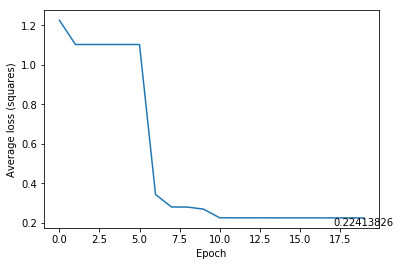

In [10]:
EPOCH = 20
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

In [11]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_V_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
print(dirname)

Cart30mm10step_201910151857_5000data20ep


In [12]:
os.mkdir(dirname)
f = open(dirname+'/params.txt','w')
f.writelines(params)
f.close()
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 2.99976413e-02  2.39811508e-08 -1.63595713e+00]
 [ 5.99669847e-02 -1.30263980e-03 -1.67939713e+00]
 [ 8.98514862e-02 -3.90553357e-03 -1.72283713e+00]
 [ 1.19594761e-01 -7.80374635e-03 -1.76627713e+00]
 [ 1.49140693e-01 -1.29899232e-02 -1.80971713e+00]
 [ 1.78433534e-01 -1.94542793e-02 -1.85315713e+00]
 [ 2.07418019e-01 -2.71846179e-02 -1.89659713e+00]
 [ 2.36039460e-01 -3.61663541e-02 -1.94003713e+00]
 [ 2.64243857e-01 -4.63825415e-02 -1.98347713e+00]
 [ 2.91977995e-01 -5.78139051e-02 -2.02691713e+00]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.         -0.06314497]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.07011434]
  [ 0.05        0.         -0.07833055]
  [ 0.0086524   0.         -0.01818096]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.0938487 ]
  [-0.00545565  0.          0.15707964]
  [ 0.05        0.         -0.04362348]]]
 --- error --- 
t [ 2.99976413e-02  2.39811508e-08 -0.

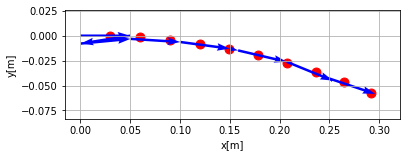

 --- grad --- 
variable([[[ 0.          0.        ]
           [ 0.          0.19824466]
           [ 0.          0.        ]
           [ 0.          0.09624196]
           [ 0.          0.04884128]
           [-0.59417444  0.04288442]
           [ 0.          0.        ]
           [ 0.          0.00843956]
           [-0.02813287  0.        ]
           [ 0.          0.        ]]])
variable([[ 0.0812327   0.1406155   0.00511307  0.09607346 -0.06425432
            0.07606087  0.0708003   0.13517168  0.10848346  0.18300842
            0.09411506  0.07852547 -0.15363714  0.12353878  0.0076145
            0.2441303   0.04923035  0.10253208  0.01333209  0.06814024]])


In [36]:
rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
d = data.rotate_path(d,rand_rad*0.5)
if DATA_RANGE_TRANSLATE != 0:
    rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
    d = data.translate_path(d,rand_trans_x,0.0)
if DATA_RANGE_ROTATE != 0:
    rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
    d = data.rotate_path(d,rand_rotate)
x_test = d
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.expand_dims(F.transpose(F.clip(y[:,:,0],-v_limit,v_limit)),axis=0)
w = F.expand_dims(F.transpose(F.clip(y[:,:,1],-w_limit,w_limit)),axis=0)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
y_pad = F.concat((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
# print(' --- trajectory --- ')
# print(Z)
# print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)
x_grad = chainer.grad( (loss,), (x,) )[0]
print(x_grad)

 --- input --- 
[[ 2.99876883e-02 -8.75470366e-08 -1.42191841e+00]
 [ 5.98278087e-02  2.97121947e-03 -1.32266841e+00]
 [ 8.92266604e-02  8.88467603e-03 -1.22341841e+00]
 [ 1.17894886e-01  1.76820791e-02 -1.12416841e+00]
 [ 1.45550319e-01  2.92768403e-02 -1.02491841e+00]
 [ 1.71920761e-01  4.35548386e-02 -9.25668407e-01]
 [ 1.96746662e-01  6.03755429e-02 -8.26418407e-01]
 [ 2.19783673e-01  7.95733960e-02 -7.27168407e-01]
 [ 2.40805053e-01  1.00959443e-01 -6.27918407e-01]
 [ 2.59603900e-01  1.24323193e-01 -5.28668407e-01]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.          0.1511666 ]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.15707964]
  [ 0.05        0.          0.15707964]
  [ 0.00915143  0.          0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.15707964]
  [-0.0009809   0.          0.15707964]
  [ 0.05        0.         -0.13387164]]]
 --- error --- 
loss: variable(0.02001231)
loss: varia

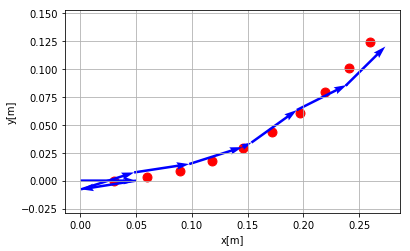

 --- input --- 
[[ 2.99923252e-02 -7.28299845e-08 -1.45325390e+00]
 [ 5.98926225e-02  2.34764876e-03 -1.37489390e+00]
 [ 8.95173892e-02  7.02875644e-03 -1.29653390e+00]
 [ 1.18684814e-01  1.40145216e-02 -1.21817390e+00]
 [ 1.47215891e-01  2.32620715e-02 -1.13981390e+00]
 [ 1.74935523e-01  3.47146526e-02 -1.06145390e+00]
 [ 2.01673588e-01  4.83019787e-02 -9.83093899e-01]
 [ 2.27265992e-01  6.39406623e-02 -9.04733899e-01]
 [ 2.51555671e-01  8.15347266e-02 -8.26373899e-01]
 [ 2.74393554e-01  1.00976194e-01 -7.48013899e-01]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.          0.11687244]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.13190614]
  [ 0.05        0.          0.1378672 ]
  [ 0.00915156  0.          0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.15707964]
  [-0.00277586  0.          0.15707964]
  [ 0.05        0.         -0.11984285]]]
 --- error --- 
loss: variable(0.02000768)
loss: varia

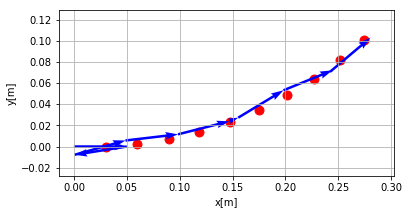

 --- input --- 
[[ 2.99792417e-02  1.40348402e-07 -1.76412101e+00]
 [ 5.97098675e-02 -3.85275791e-03 -1.89300101e+00]
 [ 8.86987333e-02 -1.14947865e-02 -2.02188101e+00]
 [ 1.16464998e-01 -2.27991864e-02 -2.15076101e+00]
 [ 1.42548102e-01 -3.75784508e-02 -2.27964101e+00]
 [ 1.66515401e-01 -5.55874348e-02 -2.40852101e+00]
 [ 1.87969348e-01 -7.65274221e-02 -2.53740101e+00]
 [ 2.06554086e-01 -1.00051080e-01 -2.66628101e+00]
 [ 2.21961348e-01 -1.25768218e-01 -2.79516101e+00]
 [ 2.33935571e-01 -1.53252267e-01 -2.92404101e+00]]
 --- output --- 
[[[ 0.05        0.          0.00111175]
  [-0.05        0.         -0.10554264]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.00749926  0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [-0.00167906  0.         -0.15394405]
  [ 0.05        0.         -0.03370394]]]
 --- error --- 
loss: variable(0.02002076)
loss: varia

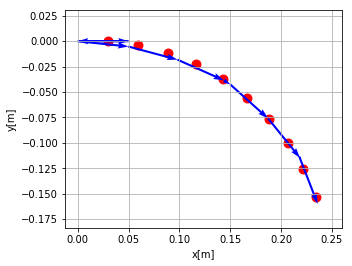

 --- input --- 
[[ 2.99999574e-02 -5.73922079e-08 -1.56203441e+00]
 [ 5.99994035e-02  1.75083972e-04 -1.55619441e+00]
 [ 8.99973152e-02  5.25418118e-04 -1.55035441e+00]
 [ 1.19992669e-01  1.05093310e-03 -1.54451441e+00]
 [ 1.49984443e-01  1.75161099e-03 -1.53867441e+00]
 [ 1.79971614e-01  2.62742790e-03 -1.53283441e+00]
 [ 2.09953158e-01  3.67835395e-03 -1.52699441e+00]
 [ 2.39928053e-01  4.90435331e-03 -1.52115441e+00]
 [ 2.69895278e-01  6.30538415e-03 -1.51531441e+00]
 [ 2.99853810e-01  7.88139870e-03 -1.50947441e+00]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.          0.00828979]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.00924556]
  [ 0.05        0.          0.00730092]
  [ 0.00895315  0.          0.0597869 ]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.04777675]
  [-0.00575702  0.          0.15707964]
  [ 0.05        0.         -0.07453173]]]
 --- error --- 
loss: variable(0.02000004)
loss: varia

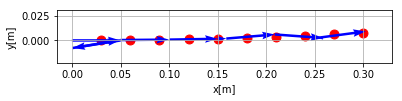

 --- input --- 
[[ 2.99984114e-02 -1.35891805e-07 -1.51731680e+00]
 [ 5.99777668e-02  1.06894515e-03 -1.48166680e+00]
 [ 8.98999688e-02  3.20588456e-03 -1.44601680e+00]
 [ 1.19726993e-01  6.40796673e-03 -1.41036680e+00]
 [ 1.49420935e-01  1.06711225e-02 -1.37471680e+00]
 [ 1.78944060e-01  1.59899343e-02 -1.33906680e+00]
 [ 2.08258851e-01  2.23576430e-02 -1.30341680e+00]
 [ 2.37328055e-01  2.97661567e-02 -1.26776680e+00]
 [ 2.66114731e-01  3.82060607e-02 -1.23211680e+00]
 [ 2.94582297e-01  4.76666296e-02 -1.19646680e+00]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.          0.0506283 ]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.05680414]
  [ 0.05        0.          0.05820816]
  [ 0.00906874  0.          0.1056359 ]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.13105044]
  [-0.00510819  0.          0.15707964]
  [ 0.05        0.         -0.09240862]]]
 --- error --- 
loss: variable(0.02000159)
loss: varia

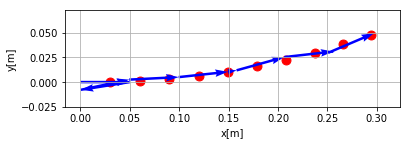

 --- input --- 
[[ 2.99757468e-02 -1.09067300e-07 -1.36182769e+00]
 [ 5.96611050e-02  4.16221010e-03 -1.22251769e+00]
 [ 8.84808939e-02  1.24063088e-02 -1.08320769e+00]
 [ 1.15876704e-01  2.45724501e-02 -9.43897688e-01]
 [ 1.41317716e-01  4.04249039e-02 -8.04587688e-01]
 [ 1.64310988e-01  5.96565146e-02 -6.65277688e-01]
 [ 1.84411004e-01  8.18946521e-02 -5.25967688e-01]
 [ 2.01228307e-01  1.06708432e-01 -3.86657688e-01]
 [ 2.14437048e-01  1.33617066e-01 -2.47347688e-01]
 [ 2.23781295e-01  1.62099173e-01 -1.08037688e-01]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.          0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.15707964]
  [ 0.05        0.          0.15707964]
  [ 0.00961125  0.          0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.15707964]
  [-0.00435922  0.          0.15707964]
  [ 0.05        0.         -0.15707964]]]
 --- error --- 
loss: variable(0.02002425)
loss: varia

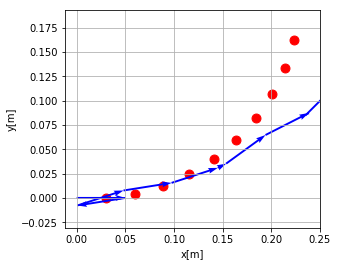

 --- input --- 
[[ 2.99816870e-02  1.22081062e-07 -1.75237540e+00]
 [ 5.97439944e-02 -3.62018305e-03 -1.87342540e+00]
 [ 8.88513445e-02 -1.08079315e-02 -1.99447540e+00]
 [ 1.16877745e-01 -2.14579288e-02 -2.11552540e+00]
 [ 1.43413023e-01 -3.54143102e-02 -2.23657540e+00]
 [ 1.68068829e-01 -5.24728208e-02 -2.35762540e+00]
 [ 1.90484320e-01 -7.23838056e-02 -2.47867540e+00]
 [ 2.10331440e-01 -9.48558631e-02 -2.59972540e+00]
 [ 2.27319723e-01 -1.19560110e-01 -2.72077540e+00]
 [ 2.41200541e-01 -1.46134993e-01 -2.84182540e+00]]
 --- output --- 
[[[ 0.05        0.          0.05693688]
  [-0.05        0.         -0.12263212]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.00751928  0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [-0.00140794  0.         -0.10451667]
  [ 0.05        0.         -0.01923148]]]
 --- error --- 
loss: variable(0.02001831)
loss: varia

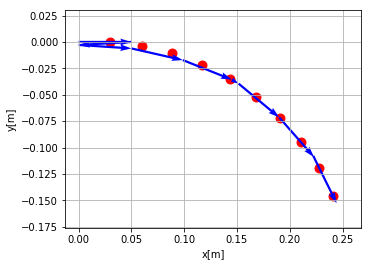

 --- input --- 
[[ 2.99997933e-02  1.16743672e-07 -1.59009022e+00]
 [ 5.99971074e-02 -3.85553230e-04 -1.60295022e+00]
 [ 8.99869815e-02 -1.15694614e-03 -1.61581022e+00]
 [ 1.19964456e-01 -2.31393442e-03 -1.62867022e+00]
 [ 1.49924573e-01 -3.85632672e-03 -1.64153022e+00]
 [ 1.79862378e-01 -5.78386797e-03 -1.65439022e+00]
 [ 2.09772921e-01 -8.09623940e-03 -1.66725022e+00]
 [ 2.39651253e-01 -1.07930586e-02 -1.68011022e+00]
 [ 2.69492435e-01 -1.38738796e-02 -1.69297022e+00]
 [ 2.99291531e-01 -1.73381928e-02 -1.70583022e+00]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.         -0.01877438]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.02121007]
  [ 0.05        0.         -0.02525898]
  [ 0.008885    0.          0.03036762]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.00581896]
  [-0.00624632  0.          0.15707964]
  [ 0.05        0.         -0.06312316]]]
 --- error --- 
loss: variable(0.02000021)
loss: varia

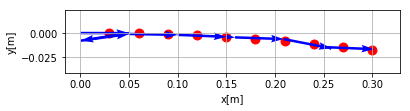

 --- input --- 
[[ 2.99918338e-02  7.04170466e-08 -1.69204367e+00]
 [ 5.98857510e-02 -2.42146039e-03 -1.77287367e+00]
 [ 8.94865462e-02 -7.24878000e-03 -1.85370367e+00]
 [ 1.18600928e-01 -1.44503663e-02 -1.93453367e+00]
 [ 1.47038783e-01 -2.39791935e-02 -2.01536367e+00]
 [ 1.74614411e-01 -3.57730389e-02 -2.09619367e+00]
 [ 2.01147748e-01 -4.97548896e-02 -2.17702367e+00]
 [ 2.26465531e-01 -6.58334450e-02 -2.25785367e+00]
 [ 2.50402438e-01 -8.39037132e-02 -2.33868367e+00]
 [ 2.72802162e-01 -1.03847697e-01 -2.41951367e+00]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.         -0.1158499 ]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.12674068]
  [ 0.05        0.         -0.14082536]
  [ 0.00820632  0.         -0.07628518]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.         -0.15707964]
  [-0.00229095  0.          0.09890499]
  [ 0.05        0.         -0.01925338]]]
 --- error --- 
loss: variable(0.02000817)
loss: varia

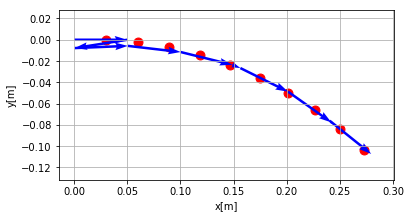

 --- input --- 
[[ 2.99724720e-02 -5.49670535e-08 -1.34816449e+00]
 [ 5.96154334e-02  4.43209059e-03 -1.19974449e+00]
 [ 8.82770922e-02  1.31989823e-02 -1.05132449e+00]
 [ 1.15327233e-01  2.61078529e-02 -9.02904493e-01]
 [ 1.40171076e-01  4.28748610e-02 -7.54484493e-01]
 [ 1.62262351e-01  6.31313323e-02 -6.06064493e-01]
 [ 1.81115315e-01  8.64318655e-02 -4.57644493e-01]
 [ 1.96315425e-01  1.12264127e-01 -3.09224493e-01]
 [ 2.07528462e-01  1.40060114e-01 -1.60804493e-01]
 [ 2.14507871e-01  1.69208646e-01 -1.23844929e-02]]
 --- output --- 
[[[ 0.05        0.          0.15707964]
  [-0.05        0.          0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.15707964]
  [ 0.05        0.          0.15707964]
  [ 0.00973459  0.          0.15707964]
  [ 0.05        0.         -0.15707964]
  [ 0.05        0.          0.15707964]
  [-0.00546574  0.          0.15707964]
  [ 0.05        0.         -0.15707964]]]
 --- error --- 
loss: variable(0.02002753)
loss: varia

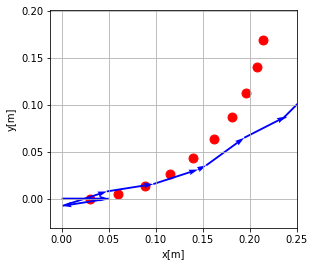

In [14]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    
    x_test = d
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.expand_dims(F.transpose(F.clip(y[:,:,0],-v_limit,v_limit)),axis=0)
    w = F.expand_dims(F.transpose(F.clip(y[:,:,1],-w_limit,w_limit)),axis=0)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
    y_pad = F.concat((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    #print(' --- trajectory --- ')
    #print(Z)
    #print(z_true.shape)
    fig = plot_path(Z,z_true)
    fig.savefig(dirname + '/test' + str(i) + '.png')